In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ColabNotebooks/Project_D

/content/drive/MyDrive/ColabNotebooks/Project_D


In [3]:
!source /content/drive/MyDrive/ColabNotebooks/Project_D/myenv/bin/activate

In [4]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
!pip install numpy==1.26.4
!pip install pandas==1.5.3
!pip install scikit-learn==1.2.2
!pip install torch==2.0.1
!pip install transformers==4.30.2
!pip install accelerate==0.18.0
!pip install sumy==0.9.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 120.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 r

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from transformers import AutoTokenizer, AutoModel, AdamW, get_cosine_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import nltk
import copy
import os
import torch.nn.functional as F

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# --- Load Data ---
train_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Project_D/new_new_train_data.csv').dropna()
test_data = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Project_D/new_new_test_data.csv').dropna()


In [3]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [4]:
train_data = train_data[~train_data['category_code'].isin(['OTHER', 'IP'])]
test_data = test_data[~test_data['category_code'].isin(['OTHER', 'IP'])]

In [5]:
all_train = train_data['category_code'].dropna().str.split().explode()

counts_train = all_train.value_counts()
counts_train

,category_code
IN,1700
OP,1700
ID,1699
HI,1000
SP,999
LY,998


In [6]:
all_train = test_data['category_code'].dropna().str.split().explode()

counts_train = all_train.value_counts()
counts_train

,category_code
IN,1700
OP,1656
ID,659
HI,303
LY,129
SP,115


In [7]:
train_data.shape

(8096, 4)

In [8]:
test_data.shape

(4562, 4)

In [9]:
le = LabelEncoder()
train_data['category_code'] = le.fit_transform(train_data['category_code'])
test_data['category_code'] = le.transform(test_data['category_code'])
num_classes = train_data['category_code'].nunique()
class_names = le.classes_

In [10]:
# Dataset
class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=512):
        self.data = dataframe.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.loc[idx, 'content'])
        inputs = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
            return_attention_mask=True
        )
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item['label'] = torch.tensor(self.data.loc[idx, 'category_code'], dtype=torch.long)
        return item

In [11]:
# Model with Mixout
class SingleModel(nn.Module):
    def __init__(self, model_name, mixout_prob=0.1):
        super(SingleModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size

        # Replace Linear layers with Mixout
        self.fc_shared = MixLinear(hidden_size, 512, target_dropout=0.3, mixout_prob=mixout_prob)
        self.relu = nn.ReLU()
        self.fc = MixLinear(512, num_classes, target_dropout=0.3, mixout_prob=mixout_prob)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # Mean Pooling over last_hidden_state
        x = outputs.last_hidden_state.mean(dim=1)
        x = self.fc_shared(x)
        x = self.relu(x)
        out = self.fc(x)
        return out


In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
        else:
            alpha = None

        CE_loss = nn.functional.cross_entropy(inputs, targets, reduction='none', weight=alpha)
        pt = torch.exp(-CE_loss)
        loss = ((1 - pt) ** self.gamma) * CE_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()


In [20]:
class MixLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, target_dropout=0.1, mixout_prob=0.0):
        super(MixLinear, self).__init__()
        self.target_dropout = target_dropout
        self.mixout_prob = mixout_prob
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.dropout = nn.Dropout(p=target_dropout)

        if mixout_prob > 0:
            self.target_weight = self.linear.weight.data.clone().detach()
            if bias:
                self.target_bias = self.linear.bias.data.clone().detach()
            else:
                self.target_bias = None
        else:
            self.target_weight = None
            self.target_bias = None

    def to(self, device):
        super().to(device)
        if self.target_weight is not None:
            self.target_weight = self.target_weight.to(device)
        if self.target_bias is not None:
            self.target_bias = self.target_bias.to(device)
        return self

    def forward(self, input):
        if self.training and self.mixout_prob > 0 and self.target_weight is not None:
            mask = (torch.rand_like(self.linear.weight) < self.mixout_prob).float()
            mixed_weight = self.linear.weight * (1 - mask) + self.target_weight * mask
            bias = self.linear.bias
            if self.target_bias is not None and bias is not None:
                mask_bias = (torch.rand_like(bias) < self.mixout_prob).float()
                bias = bias * (1 - mask_bias) + self.target_bias * mask_bias
            return F.linear(input, mixed_weight, bias)
        else:
            input = self.dropout(input)
            return self.linear(input)


In [14]:
# Stratified Split
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
train_idx, val_idx = next(skf.split(train_data, train_data['category_code']))
train_df = train_data.iloc[train_idx]
val_df = train_data.iloc[val_idx]

In [15]:
# Tokenizer
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_dataset = TextDataset(train_df, tokenizer)
val_dataset = TextDataset(val_df, tokenizer)
test_dataset = TextDataset(test_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [21]:
# Training Setup
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = SingleModel(model_name).to(device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SingleModel(model_name).to(device)

model.fc_shared.target_weight = model.fc_shared.target_weight.to(device)
if model.fc_shared.target_bias is not None:
    model.fc_shared.target_bias = model.fc_shared.target_bias.to(device)

model.fc.target_weight = model.fc.target_weight.to(device)
if model.fc.target_bias is not None:
    model.fc.target_bias = model.fc.target_bias.to(device)


# class_weights_tensor = torch.tensor(compute_class_weight('balanced', classes=np.unique(train_df['category_code']), y=train_df['category_code']), dtype=torch.float).to(device)
class_weights_tensor = torch.tensor(
    compute_class_weight('balanced', classes=np.unique(train_df['category_code']), y=train_df['category_code']),
    dtype=torch.float
).to(device)

criterion = FocalLoss(alpha=class_weights_tensor)


# criterion = FocalLoss(alpha=class_weights_tensor)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_loader)*5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (in

In [22]:
checkpoint_path = '/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/checkpoint.pt'

loss_per_epoch = []
f1_per_epoch = []
best_f1 = 0
patience = 3
early_stop_counter = 0
start_epoch = 0
best_model = None
accumulation_steps = 2

In [31]:
# Load from checkpoint if exists
if os.path.exists(checkpoint_path):
    print("Loading checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    early_stop_counter = checkpoint['early_stop_counter']
    loss_per_epoch = checkpoint.get('loss_per_epoch', [])
    f1_per_epoch = checkpoint.get('f1_per_epoch', [])
    best_model = copy.deepcopy(model.state_dict())
    print(f"Resuming training from epoch {start_epoch} with best F1: {best_f1:.4f}")

Loading checkpoint...
Resuming training from epoch 5 with best F1: 0.8092


In [32]:
# Training Loop
for epoch in range(start_epoch, 10):
    model.train()
    total_loss = 0
    optimizer.zero_grad()
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)  # Move labels to the device

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels) / accumulation_steps
        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    loss_per_epoch.append(avg_loss)

    # Validation
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device) # Move labels to the device

            outputs = model(input_ids, attention_mask)
            pred = torch.argmax(outputs, dim=1)
            preds.extend(pred.cpu().numpy())
            trues.extend(labels.cpu().numpy())

    f1 = f1_score(trues, preds, average='macro')
    f1_per_epoch.append(f1)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Validation F1: {f1:.4f}")

    # Save best model
    if f1 > best_f1:
        best_f1 = f1
        best_model = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping.")
            break

    # Save checkpoint after each epoch
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_f1': best_f1,
        'early_stop_counter': early_stop_counter,
        'loss_per_epoch': loss_per_epoch,
        'f1_per_epoch': f1_per_epoch
    }, checkpoint_path)

# Save Best Model
if best_model is not None:
    torch.save(best_model, '/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/best_model.pth')
else:
     print("Warning: No improvement during training, best model was not saved.")

Epoch 6: 100%|██████████| 506/506 [07:11<00:00,  1.17it/s, loss=0.00536]


Epoch 6 | Loss: 0.0298 | Validation F1: 0.8207


Epoch 7: 100%|██████████| 506/506 [07:14<00:00,  1.17it/s, loss=0.00307]


Epoch 7 | Loss: 0.0165 | Validation F1: 0.8173


Epoch 8: 100%|██████████| 506/506 [07:13<00:00,  1.17it/s, loss=0.00453]


Epoch 8 | Loss: 0.0101 | Validation F1: 0.8147


Epoch 9: 100%|██████████| 506/506 [07:12<00:00,  1.17it/s, loss=0.00354]


Epoch 9 | Loss: 0.0070 | Validation F1: 0.8187
Early stopping.


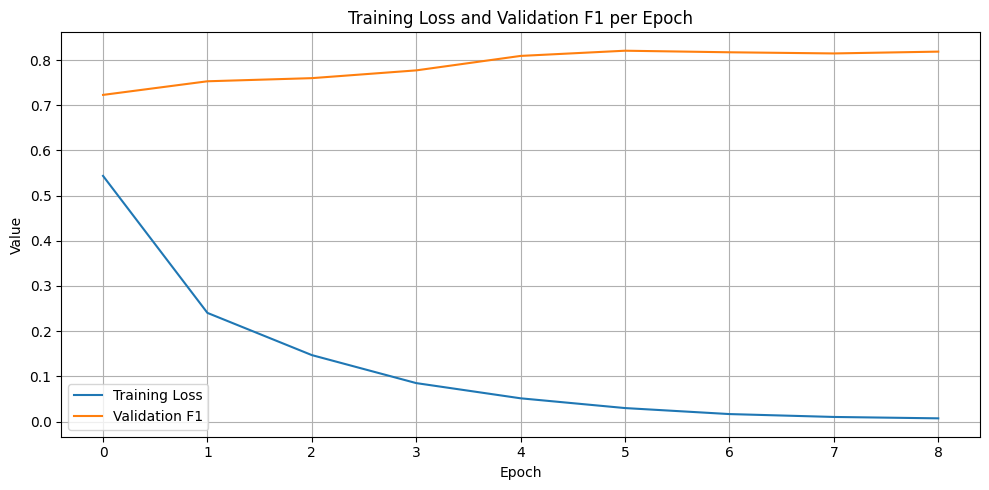

In [33]:
import matplotlib.pyplot as plt

# Plotting Loss and F1
plt.figure(figsize=(10, 5))
plt.plot(loss_per_epoch, label='Training Loss')
plt.plot(f1_per_epoch, label='Validation F1')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation F1 per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/loss_f1_curve.png')
plt.show()

In [34]:
# Ensemble Inference (for simplicity, using same model 3 times)
model.load_state_dict(torch.load('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/best_model.pth'))
model.eval()
all_preds, all_trues = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_trues.extend(labels.cpu().numpy())

In [35]:
np.save('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/all_preds.npy', np.array(all_preds))
np.save('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/all_trues.npy', np.array(all_trues))

In [36]:
all_preds = np.load('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/all_preds.npy')
all_trues = np.load('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/all_trues.npy')

In [37]:
print(classification_report(all_trues, all_preds, target_names=class_names))
print("Accuracy:", accuracy_score(all_trues, all_preds))

              precision    recall  f1-score   support

          HI       0.46      0.78      0.58       303
          ID       0.77      0.84      0.80       659
          IN       0.87      0.61      0.72      1700
          LY       0.86      0.91      0.89       129
          OP       0.71      0.78      0.75      1656
          SP       0.55      0.83      0.66       115

    accuracy                           0.73      4562
   macro avg       0.70      0.79      0.73      4562
weighted avg       0.76      0.73      0.73      4562

Accuracy: 0.7321350284962735


In [38]:
from matplotlib import pyplot as plt
from PIL import Image

report = classification_report(all_trues, all_preds, target_names=class_names)
accuracy = accuracy_score(all_trues, all_preds)

text = f"Classification Report:\n{report}\nAccuracy: {accuracy:.4f}"

fig, ax = plt.subplots(figsize=(10, 6))
ax.axis("off")
ax.text(0, 1, text, fontsize=10, va='top', family='monospace')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/classification_report.png", dpi=600)
plt.close()


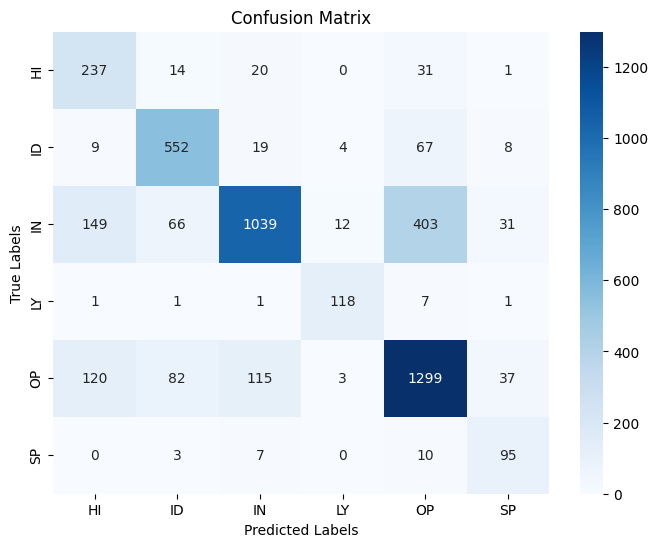

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(all_trues, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('/content/drive/MyDrive/ColabNotebooks/Project_D/bert_base_model/confusion_matrix.png', dpi=600)
plt.show()
